## Imports

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from clique_finding_models.analysis import load_experiment_results, get_exp_ids_from_sacred_dir, \
    process_exp_results_to_df

## Load configs and metrics

In [2]:
SACRED_DIR = os.path.join(os.getcwd(), "outputs", "small_500", "sacred")
changing_hparams = [
    "conv_layers",
    "hidden_layers",
    "learning_rate",
]

exp_ids = get_exp_ids_from_sacred_dir(SACRED_DIR)
exp_results = [load_experiment_results(os.path.join(SACRED_DIR, str(exp_id)))
               for exp_id in exp_ids]
results = process_exp_results_to_df(exp_ids, exp_results, changing_hparams)
results.loc[results.data_set == "small_dimacs_bhoslib_500", "data_set"] = "all"
results.loc[results.train == True, "model"] = results.loc[results.train == True, "model"] + "_subset"
results.head()

,batch_size,data_set,status,train,transform_y,exp_id,tag,epochs,model,train.mse,...,train.top5,val.frac_mc,train.mae,train.avep,train.frac_mc,val.mse,val.top5,learning_rate,hidden_layers,conv_layers
0,32,all,COMPLETED,True,none,2,abs,2,mean_bl_subset,17.072184,...,0.6816,0.664060,3.62971,0.670625,0.674661,16.339006,0.6796,NaN,NaN,NaN
1,32,dsjc20,COMPLETED,False,none,3,abs,1,mean_bl,NaN,...,NaN,0.602579,NaN,NaN,NaN,10.828598,0.6560,NaN,NaN,NaN
2,32,rb5-4,COMPLETED,False,none,4,abs,1,mean_bl,NaN,...,NaN,0.723772,NaN,NaN,NaN,10.014274,0.7440,NaN,NaN,NaN
3,32,C.20.5,COMPLETED,False,none,5,abs,1,mean_bl,NaN,...,NaN,0.497380,NaN,NaN,NaN,9.929703,0.4860,NaN,NaN,NaN
4,32,C.20.9,COMPLETED,False,none,6,abs,1,mean_bl,NaN,...,NaN,0.793121,NaN,NaN,NaN,16.781613,0.7980,NaN,NaN,NaN


## Regression

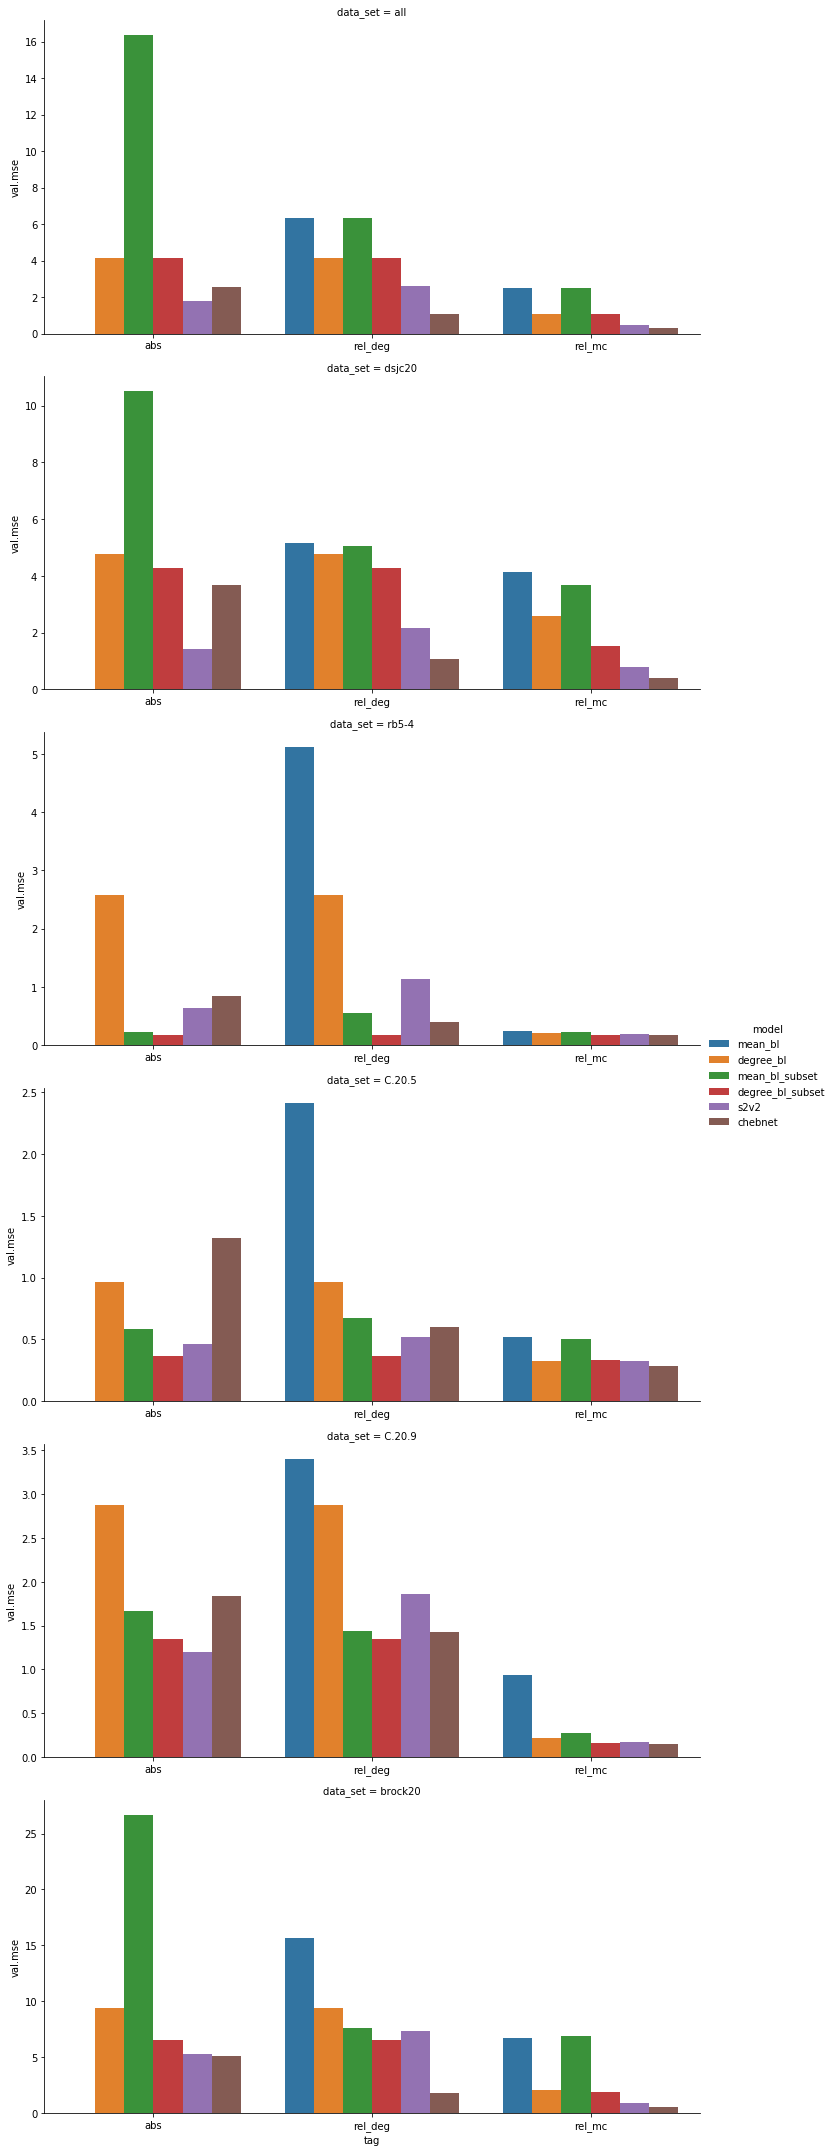

In [3]:
mse_model_order = ["mean_bl", "degree_bl", "mean_bl_subset", "degree_bl_subset", "s2v2", "chebnet"]
mse_tag_order = ["abs", "rel_deg", "rel_mc"]

sns.catplot(data=results[((results.model != "mean_bl") | (results.tag != "abs"))], 
            x="tag", y="val.mse", row="data_set", hue="model",
            hue_order=mse_model_order, order=mse_tag_order, 
            kind="bar", sharey=False, aspect=2, sharex=False)

### Generate figures and tables

/home/mario/Documents/matfyz/mcp-gnns/env/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


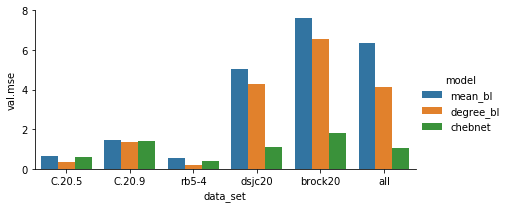

In [4]:
selected_models = ["mean_bl_subset", "degree_bl_subset","chebnet"]
mse_tag_order = ["abs", "rel_deg"]

data = results.loc[(results.tag == "rel_deg") & (results.model.isin(selected_models)), :]
data.loc[data.model == "mean_bl_subset", "model"] = "mean_bl"
data.loc[data.model == "degree_bl_subset", "model"] = "degree_bl"

grid = sns.catplot(data=data, 
            x="data_set", y="val.mse", hue="model",
            order=["C.20.5", "C.20.9", "rb5-4", "dsjc20", "brock20", "all"],
            hue_order=["mean_bl", "degree_bl","chebnet"],
            kind="bar", aspect=2, height=3, sharex=False)

# grid.savefig("outputs/per_dataset_mse.png", dpi=300)

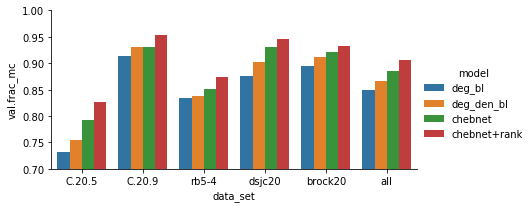

In [5]:
selected_models = ["rank_deg_bl", "rank_deg_den_bl", "chebnet"]
data = results.loc[(results.tag.isin(["rel_deg"])) & (results.model.isin(selected_models)), :]
data = pd.concat([data, results.loc[(results.model == "chebnet") & (results.tag == "rank"), :]], sort=True).reset_index()

data.loc[data.model == "rank_deg_bl", "model"] = "deg_bl"
data.loc[data.model == "rank_deg_den_bl", "model"] = "deg_den_bl"
data.loc[(data.model == "chebnet") & (data.tag == "rank"), "model"] = "chebnet+rank"

grid = sns.catplot(data=data, 
            x="data_set", y="val.frac_mc", hue="model",
            order=["C.20.5", "C.20.9", "rb5-4", "dsjc20", "brock20", "all"],
            hue_order=["deg_bl", "deg_den_bl", "chebnet", "chebnet+rank"],
            kind="bar", aspect=2, height=3)
grid.axes[0,0].set_ylim(0.7, 1)

# grid.savefig("outputs/per_dataset_rank.png", dpi=300)

In [6]:
col_order = [
    "mean_bl_subset+abs",
    "degree_bl_subset+abs",
    "s2v2+abs",
    "chebnet+abs",
    
    "mean_bl_subset+rel_deg",
    "degree_bl_subset+rel_deg",
    "s2v2+rel_deg",
    "chebnet+rel_deg",
    
    "mean_bl_subset+rel_mc",
    "degree_bl_subset+rel_mc",
    "s2v2+rel_mc",
    "chebnet+rel_mc",
]
table = results.loc[
    (results.model.isin(["mean_bl_subset", "degree_bl_subset", "s2v2", "chebnet"])) &
    (results.tag != "rank"), 
    ["model", "tag", "data_set", "val.mse"]].reset_index()
table["model_tag"] = table["model"] + "+" + table["tag"]
table = table.pivot("data_set", "model_tag", "val.mse").round(2)[col_order]
#table.groupby(["model", "tag", "data_set"]).count()
table

model_tag,mean_bl_subset+abs,degree_bl_subset+abs,s2v2+abs,chebnet+abs,mean_bl_subset+rel_deg,degree_bl_subset+rel_deg,s2v2+rel_deg,chebnet+rel_deg,mean_bl_subset+rel_mc,degree_bl_subset+rel_mc,s2v2+rel_mc,chebnet+rel_mc
data_set,,,,,,,,,,,,
C.20.5,0.58,0.37,0.46,1.32,0.67,0.37,0.52,0.60,0.50,0.33,0.32,0.28
C.20.9,1.67,1.35,1.20,1.84,1.43,1.35,1.86,1.43,0.28,0.16,0.17,0.15
all,16.34,4.12,1.80,2.55,6.36,4.12,2.60,1.06,2.50,1.09,0.48,0.32
brock20,26.70,6.55,5.29,5.07,7.63,6.55,7.34,1.80,6.88,1.87,0.93,0.57
dsjc20,10.51,4.26,1.42,3.67,5.07,4.26,2.16,1.09,3.68,1.54,0.78,0.42
rb5-4,0.22,0.17,0.64,0.84,0.55,0.17,1.13,0.40,0.22,0.17,0.20,0.18


In [7]:
# with open("outputs/subsets_small_500.tex", "w") as f:
#     f.write(table.to_latex())

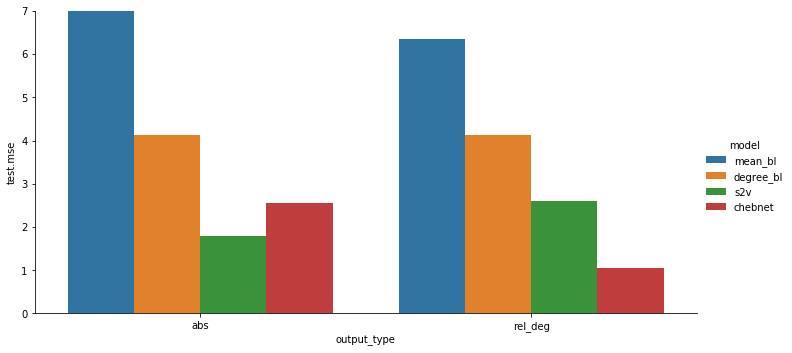

In [8]:
data = results.loc[(results.data_set == "all"), :]
data = data.rename(index=str, columns={
    "tag": "output_type", "val.mse": "test.mse"})
data.loc[data.model == "s2v2", "model"] = "s2v"

#sns.set(font_scale=1.5) 

model_order = ["mean_bl", "degree_bl", "s2v", "chebnet"]
grid = sns.catplot(data=data, 
            x="output_type", y="test.mse", hue="model",
            hue_order=model_order, order=["abs", "rel_deg"], 
            kind="bar", sharey=False, aspect=2, sharex=False)
grid.axes[0,0].set_ylim(0,7)

# grid.savefig("outputs/mse_subsets.png")

## Ranking task

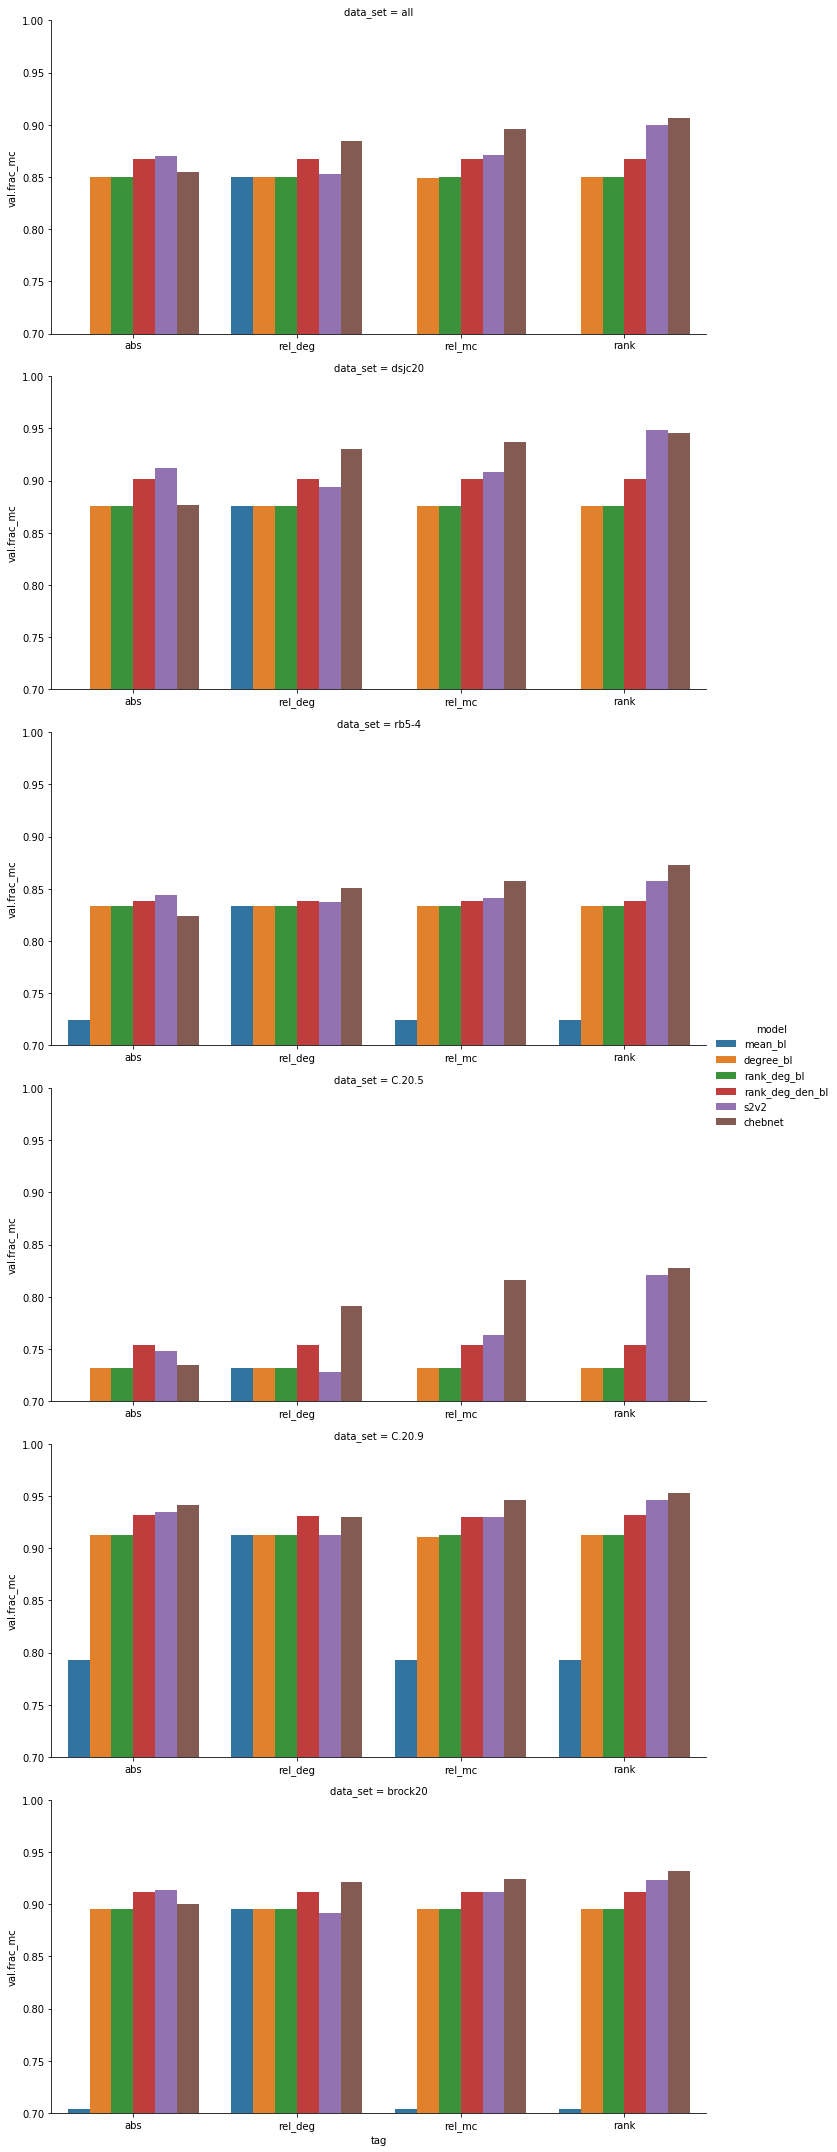

In [9]:
rank_model_order = ["mean_bl", "degree_bl", "rank_deg_bl","rank_deg_den_bl", "s2v2", "chebnet"]
rank_tag_order = ["abs", "rel_deg", "rel_mc", "rank"]

grid = sns.catplot(data=results, 
            x="tag", y="val.frac_mc", row="data_set", hue="model",
            hue_order=rank_model_order, order=rank_tag_order, 
            kind="bar", sharey=False, sharex=False, aspect=2)
for i in range(6):
    grid.axes[i, 0].set_ylim(0.7, 1)

### Generate figures and tables

In [10]:
col_order = [
    "mean_bl+abs",
    "rank_deg_bl+abs",
    "rank_deg_den_bl+abs",
    
    "s2v2+abs",
    "chebnet+abs",
    
    "s2v2+rel_deg",
    "chebnet+rel_deg",
    
    "s2v2+rel_mc",
    "chebnet+rel_mc",
    
    "s2v2+rank",
    "chebnet+rank",
]
table = results.loc[
    (results.model.isin(["mean_bl", "rank_deg_bl", "rank_deg_den_bl", "s2v2", "chebnet"])), 
    ["model", "tag", "data_set", "val.frac_mc"]].reset_index()
table["model_tag"] = table["model"] + "+" + table["tag"]
table = table.pivot("data_set", "model_tag", "val.frac_mc").round(3)[col_order]
table

model_tag,mean_bl+abs,rank_deg_bl+abs,rank_deg_den_bl+abs,s2v2+abs,chebnet+abs,s2v2+rel_deg,chebnet+rel_deg,s2v2+rel_mc,chebnet+rel_mc,s2v2+rank,chebnet+rank
data_set,,,,,,,,,,,
C.20.5,0.497,0.732,0.754,0.748,0.734,0.728,0.792,0.763,0.816,0.821,0.827
C.20.9,0.793,0.913,0.931,0.934,0.941,0.913,0.930,0.930,0.946,0.947,0.953
all,0.664,0.850,0.867,0.871,0.855,0.853,0.885,0.871,0.896,0.899,0.906
brock20,0.703,0.895,0.912,0.914,0.900,0.891,0.921,0.912,0.924,0.923,0.932
dsjc20,0.603,0.876,0.901,0.912,0.877,0.894,0.930,0.908,0.937,0.949,0.946
rb5-4,0.724,0.833,0.838,0.844,0.824,0.837,0.851,0.841,0.858,0.858,0.873


In [11]:
# with open("outputs/subsets_small_500_rank.tex", "w") as f:
#     f.write(table.to_latex())

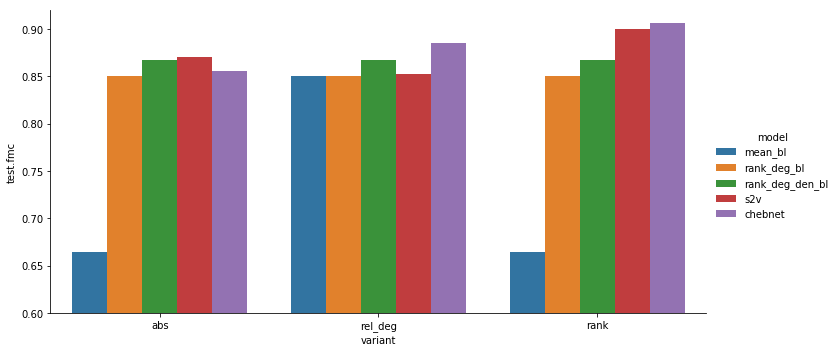

In [12]:
data = results.loc[(results.data_set == "all"), :]
data = data.rename(index=str, columns={"tag": "variant", "val.frac_mc": "test.fmc"})
data.loc[data.model == "s2v2", "model"] = "s2v"

# sns.set(font_scale=1.5) 

model_order = ["mean_bl", "rank_deg_bl", "rank_deg_den_bl", "s2v", "chebnet"]
tag_order = ["abs", "rel_deg", "rank"]
grid = sns.catplot(data=data, 
            x="variant", y="test.fmc", hue="model",
            hue_order=model_order, order=tag_order, 
            kind="bar", sharey=False, aspect=2, sharex=False)
grid.axes[0,0].set_ylim(0.6,0.92)
grid
# grid.savefig("outputs/rank_subsets.png")

(0.6, 1)

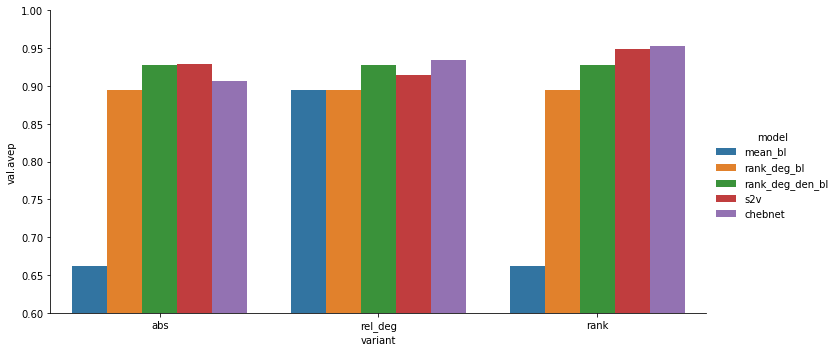

In [13]:
grid = sns.catplot(data=data, 
            x="variant", y="val.avep", hue="model",
            hue_order=model_order, order=tag_order, 
            kind="bar", sharey=False, aspect=2, sharex=False)
grid.axes[0,0].set_ylim(0.6,1)

(0.6, 1)

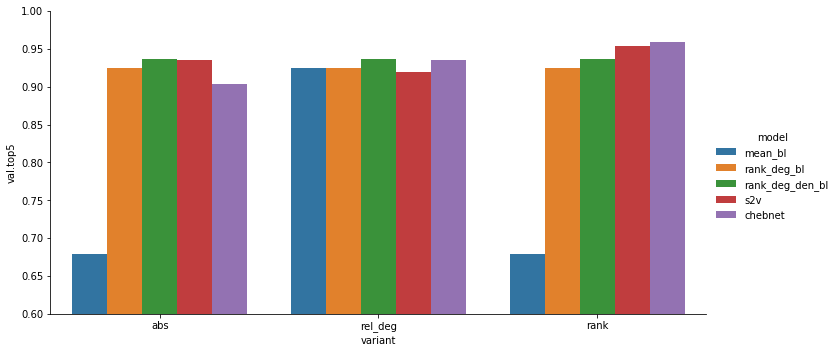

In [14]:
grid = sns.catplot(data=data, 
            x="variant", y="val.top5", hue="model",
            hue_order=model_order, order=tag_order, 
            kind="bar", sharey=False, aspect=2, sharex=False)
grid.axes[0,0].set_ylim(0.6,1)

## Average precision and precision@k on subsets

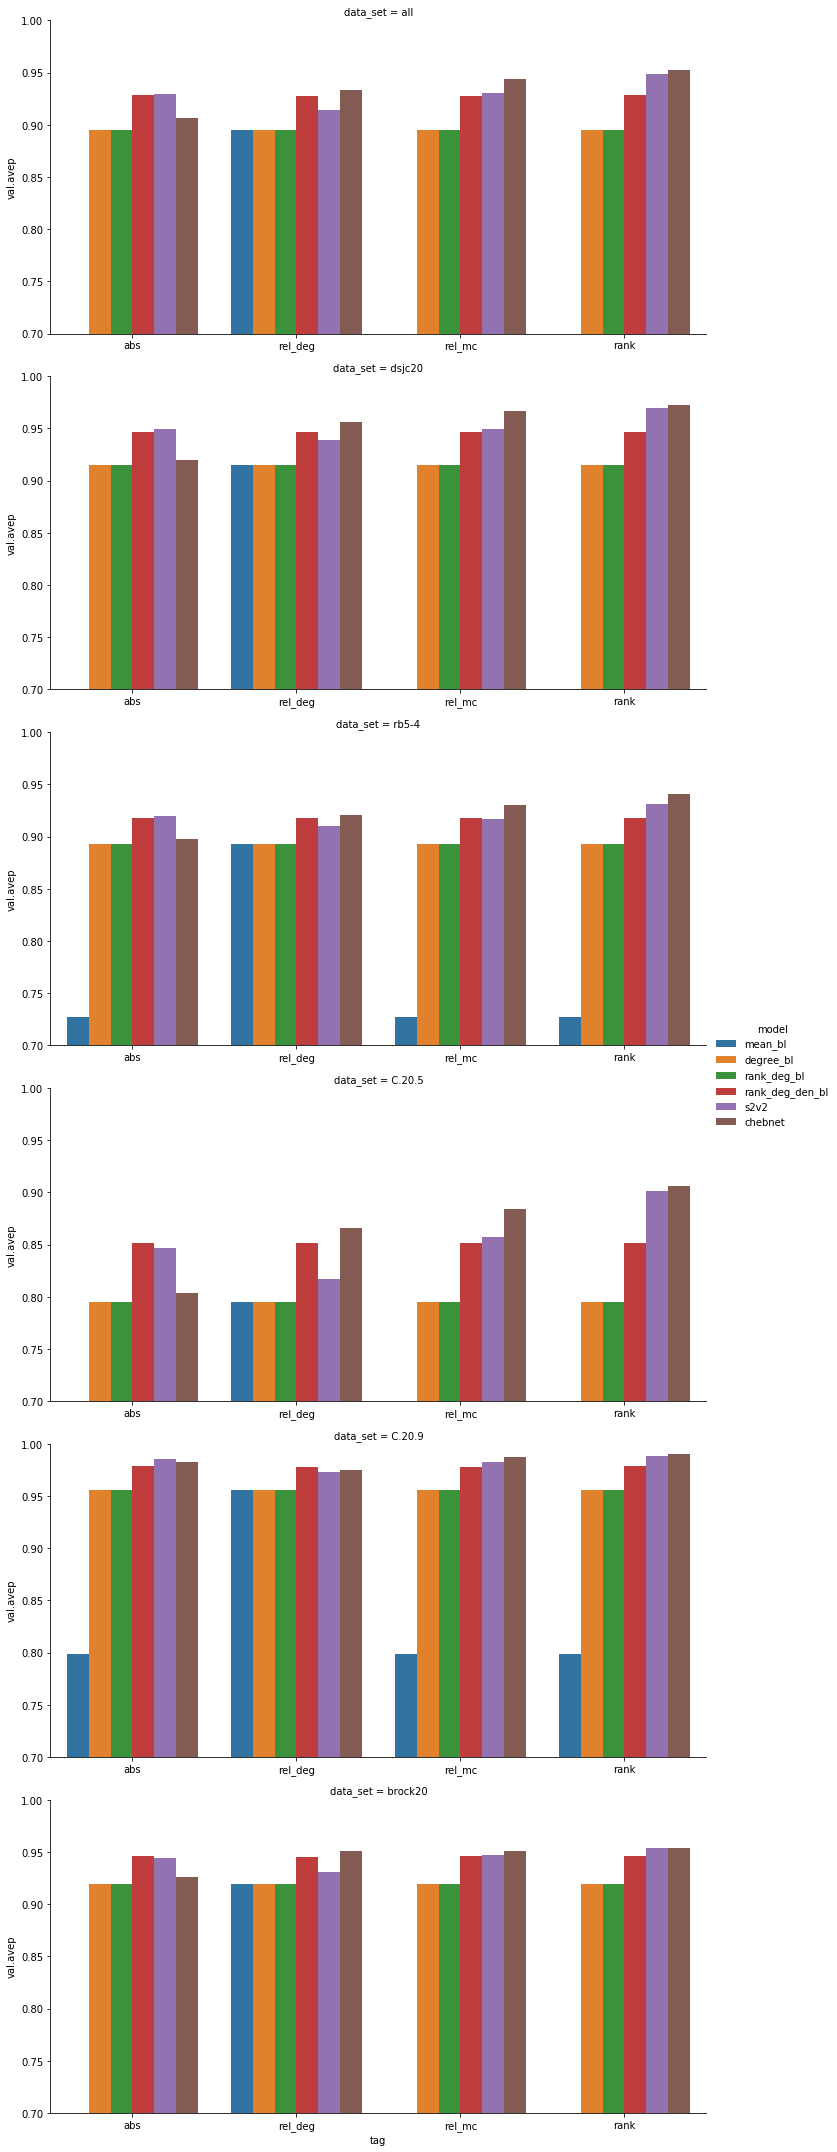

In [15]:
rank_model_order = ["mean_bl", "degree_bl", "rank_deg_bl", "rank_deg_den_bl", "s2v2", "chebnet"]
rank_tag_order = ["abs", "rel_deg", "rel_mc", "rank"]

grid = sns.catplot(data=results, 
            x="tag", y="val.avep", row="data_set", hue="model",
            hue_order=rank_model_order, order=rank_tag_order, 
            kind="bar", sharey=False, sharex=False, aspect=2)
for i in range(6):
    grid.axes[i, 0].set_ylim(0.7, 1)

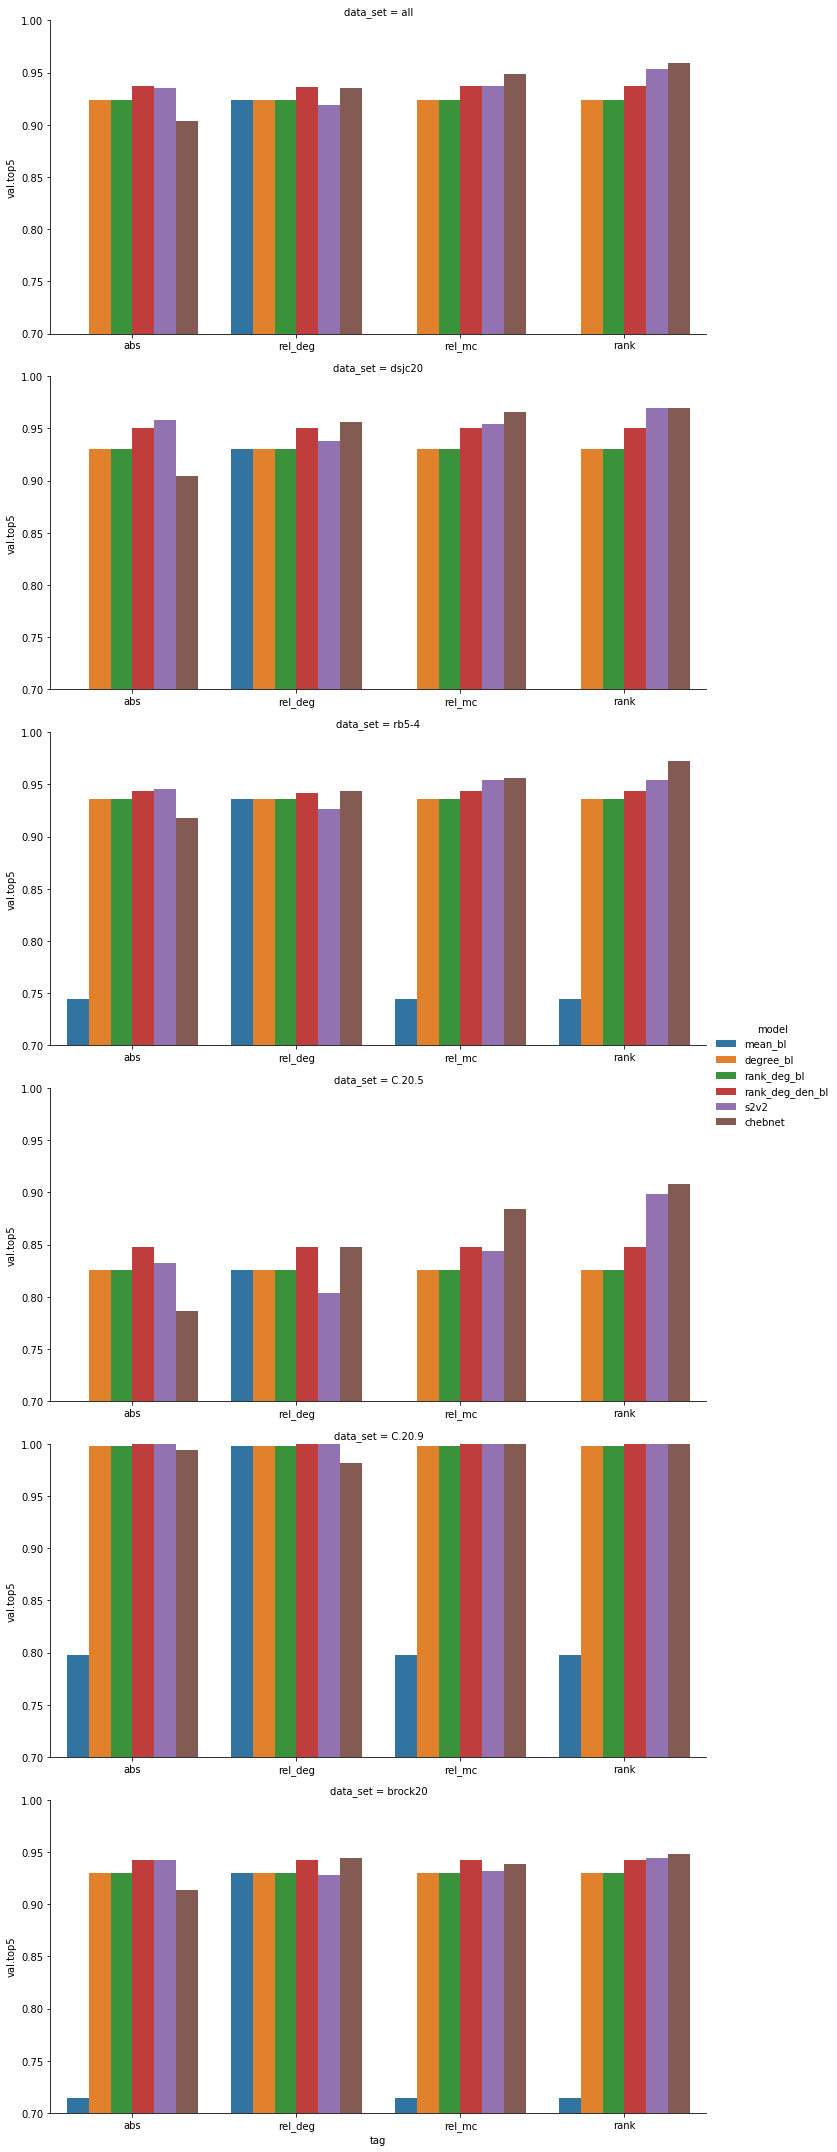

In [16]:
grid = sns.catplot(data=results, 
            x="tag", y="val.top5", row="data_set", hue="model",
            hue_order=rank_model_order, order=rank_tag_order, 
            kind="bar", sharey=False, sharex=False, aspect=2)
for i in range(6):
    grid.axes[i, 0].set_ylim(0.7, 1)